<a href="https://colab.research.google.com/github/ealeongomez/Deep-Learning/blob/master/KCCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Modelo matemático**

1. Datos de entrada: 

Dados un par de vectores de entrada 
$$x_a \epsilon X_a ; x_b \epsilon X_b$$

Kernels definidos 
$$K_a: X_a x X_a \rightarrow R ; K_b: X_b x X_b \rightarrow R$$

Propiedades reproductivas del kernel:

$$Z_a = K_a \alpha_a$$
$$Z_b = K_b \alpha_b$$

Restricciones:
$$K_a \epsilon R^{NxN}$$ 
$$K_b \epsilon R^{NxN}$$ 

2. Función de costo

$$cos(\theta) = max <Z_a, Z_b> = < K_a\alpha_a, K_b\alpha_b> = \alpha_a^\top K_a^\top K_b\alpha_b$$

s.t. $||Z_a||_2 = ||Z_b||_2 = 1$

3. Solución de la función de costo:

$$\alpha_a = \frac{1}{\rho} (K_a + \lambda_a I)^{-2} K_a^\top K_b \alpha_b$$

$$A \alpha_b = \rho^2 \alpha_b$$

In [12]:
import tensorflow as tf
import tensorflow_probability as tfp 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

print('Training samples: ', X_train.shape[0])
print('Test samples: ', X_test.shape[0])
print('Validation samples: ', X_valid.shape[0])

11493376/11490434 [==============================] - 0s 0us/step
Training samples:  55000
Test samples:  10000
Validation samples:  5000


In [4]:
class MyRegularizer(tf.keras.regularizers.Regularizer): 
    def __init__(self, lam=2.0):
        self.lam = lam

    def __call__(self, x):
        E = tf.linalg.matmul(x,x,transpose_a=True)-tf.eye(tf.shape(x)[1]) 
        return self.lam * tf.linalg.trace(tf.linalg.matmul(E,E))

  
def custom_loss(num):  
    @tf.function()
    def custom_cca_loss(y_true,y_pred):
      y_1 = y_pred[:,:num] 
      y_2 = y_pred[:,num:] 
      
      norm_y1 = tf.reshape(tf.norm(y_1,axis=0),(-1,1))
      norm_y2 = tf.reshape(tf.norm(y_2,axis=0),(-1,1))
      norm_matrix = tf.linalg.matmul(norm_y1,norm_y2,transpose_b=True)

      f = tf.linalg.matmul(y_1,y_2,transpose_a=True)/norm_matrix
      f = tf.reduce_mean(f) 
      return -f
    return custom_cca_loss

In [5]:
tf.keras.backend.clear_session()

In [6]:
l1 = 1e-3
l2 = 1e-3
     
# Entradas del modelo 
input = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
input_x = tf.keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2]), name="Input_X")(input)
input_y = tf.keras.layers.Input(shape=(1), name="Input_y")

# Rotación del espacio
rotate_x = tf.keras.layers.Dense(100, 
                                 activation='linear',
                                 use_bias=False,
                                 name='projection1',
                                 kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(input_x)

rotate_y = tf.keras.layers.Dense(100,
                                 activation='linear',
                                 use_bias=False,
                                 name='projection2',
                                 kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1,l2=l2))(input_y)


# Capas Random Fourier Feature (RFF)
RFF_x =  tf.keras.layers.experimental.RandomFourierFeatures(output_dim=20,
                                                            scale=11,
                                                            kernel_initializer='gaussian',
                                                            trainable= True,
                                                            name='rbf_fourier_a')(rotate_x)

RFF_y =  tf.keras.layers.experimental.RandomFourierFeatures(output_dim=20,
                                                            scale=11,
                                                            kernel_initializer='gaussian',
                                                            trainable= True,
                                                            name='rbf_fourier_b')(rotate_y)


# Capas densas del modelos 
dense_x = tf.keras.layers.Dense(2, 
                                activation='linear',
                                use_bias=False,
                                name='ouput1',
                                kernel_regularizer=MyRegularizer())(RFF_x)

dense_y = tf.keras.layers.Dense(2,
                                activation='linear',
                                use_bias=False,
                                name='ouput2',
                                kernel_regularizer=MyRegularizer())(RFF_y) 

# Capa de concatenación
concat = tf.keras.layers.Concatenate()([dense_x, dense_y])

# Creación del modelo
model = tf.keras.Model(inputs=[input, input_y], outputs=[concat])



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
Input_X (Flatten)               (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
Input_y (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
projection1 (Dense)             (None, 100)          78400       Input_X[0][0]                    
_______________________________________________________________________________________

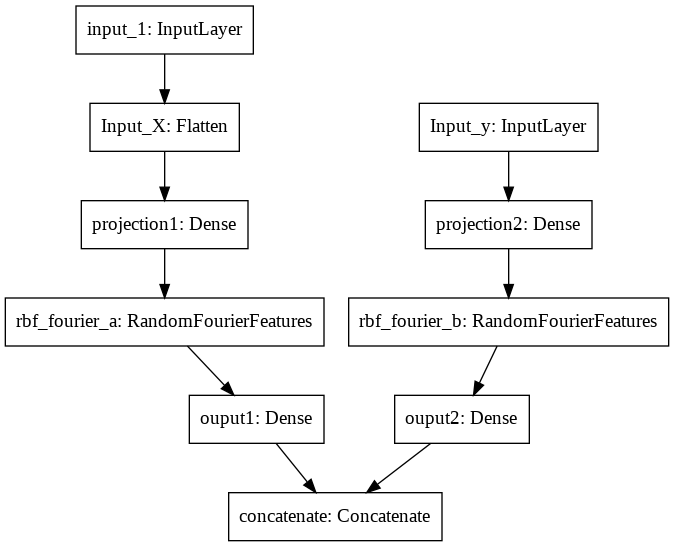

In [7]:
# Esquema del modelo  
model.summary()
tf.keras.utils.plot_model(model)

In [8]:
model.compile(loss=[custom_loss(2)],
              metrics=custom_loss(2))


In [10]:
history = model.fit(x=[X_train, y_train], y=[y_train],
                   epochs=50,
                   batch_size=240,
                   validation_split=0.2)

Epoch 1/50
184/184 [==============================] - 1s 5ms/step - loss: 0.4966 - custom_cca_loss: -0.8733 - val_loss: -0.8838 - val_custom_cca_loss: -0.9565
Epoch 2/50
184/184 [==============================] - 1s 4ms/step - loss: -0.9307 - custom_cca_loss: -0.9860 - val_loss: -0.9498 - val_custom_cca_loss: -0.9968
Epoch 3/50
184/184 [==============================] - 1s 4ms/step - loss: -0.9553 - custom_cca_loss: -0.9989 - val_loss: -0.9586 - val_custom_cca_loss: -0.9999
Epoch 4/50
184/184 [==============================] - 1s 4ms/step - loss: -0.9598 - custom_cca_loss: -1.0000 - val_loss: -0.9601 - val_custom_cca_loss: -1.0000
Epoch 5/50
184/184 [==============================] - 1s 4ms/step - loss: -0.9604 - custom_cca_loss: -1.0000 - val_loss: -0.9605 - val_custom_cca_loss: -1.0000
Epoch 6/50
184/184 [==============================] - 1s 4ms/step - loss: -0.9606 - custom_cca_loss: -1.0000 - val_loss: -0.9605 - val_custom_cca_loss: -1.0000
Epoch 7/50
184/184 [=====================

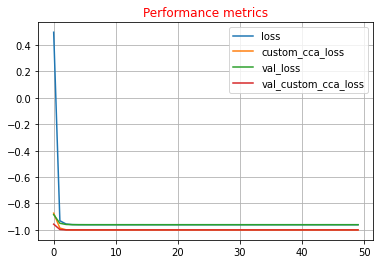

In [14]:
hpd = pd.DataFrame(history.history)

hpd.plot()
plt.title('Performance metrics', c='r')
plt.grid(True)
plt.show()